Stack overflow  case study 
> question taging

In [2]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import sqlite3 
import seaborn as sns
import re
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from datetime  import datetime

 # Problem:
  ### 1.given the title and the drecption we have to suggest the tag with high precision and recall
  ### 2.incorrect tag could impact customer exp on stckOverflow
  ### 3.No strict latency constraints
# Given:
 ### >the user drecption,and title to suggest the tag

# Data
  #### train.csv--> 60,34,195
  #### columns-->ID,Title,Body,Tags.

# ML problem:
  #### it is a multilabel problem because it can have many tage of the one question 
  #### 1.since we need heigh precision and recall we will use f1-score for this 
  ####  i.e  f1= 2*((pre*recall)/(prec+recall))    
  #### we can use the f1 directly for multilabel problem we will use mean f1 score  

## Data loading 

In [ ]:
if not os.path.isfile('Train.db'):
  disk_eng = create_engine('sqlite:///Train.db')
  start = datetime.now()
  chunk=180000
  j=0
  start_index=1
  for df in pd.read_csv('/content/drive/MyDrive/machine learning/StackOverflow/Train.zip',chunksize=chunk,names=['Id','Title','Body','Tags'],encoding='utf-8',iterator=True):
    df.index+=start_index
    j+=1
    print('{}row'.format(j*chunk))
    df.to_sql('data',disk_eng,if_exists='append')
    start_index=df.index[-1]+1
  print('Time taken=',datetime.now()-start)

## removing the duplicate

In [ ]:
if os.path.isfile('/content/drive/MyDrive/machine learning/StackOverflow/Train.db'):
  start = datetime.now()
  con = sqlite3.connect('/content/drive/MyDrive/machine learning/StackOverflow/Train.db')
  no_dup=pd.read_sql_query('SELECT Title,Body,Tags,count(*) as dup_cnt FROM data GROUP BY Title, Body, Tags', con)  
  con.close()
  print("time taken=",datetime.now()-start)
else:
  print("file not found")

time taken= 0:06:48.442222


In [ ]:
### find the number of duplicates
print(6120000-no_dup.shape[0])

1913685


In [ ]:
no_dup.head()

,Title,Body,Tags,dup_cnt
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [ ]:
### counting the numbers of tag
start = datetime.now()
no_dup["Tag_cnt"]=no_dup["Tags"].apply(lambda text: len(str(text).split()))
print('time taken =',datetime.now()-start)
no_dup.head()

time taken = 0:00:03.221444


,Title,Body,Tags,dup_cnt,Tag_cnt
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


## Tag analysis

In [ ]:
start = datetime.now()
eng = create_engine('sqlite:///train_no_dup.db')
no_dup_df = pd.DataFrame(no_dup,columns=['Title','Body','Tags'])
no_dup_df.to_sql('no_dup',eng)
print('time taken=',datetime.now()-start)



time taken= 0:02:08.432302


In [ ]:
start = datetime.now()
con = sqlite3.connect('/content/train_no_dup.db')
tag = pd.read_sql_query('SELECT Tags FROM no_dup',con)
tag.head()
print("time take=",datetime.now()-start)

time take= 0:01:54.187768


In [ ]:
vector = CountVectorizer(tokenizer=lambda x: x.split(' '))
tag.dropna(inplace=True)
tag_vec= vector.fit_transform(tag['Tags'])

In [ ]:
tag_vec.shape


(4206308, 42048)

In [ ]:
unique_tag = vector.get_feature_names()
len(unique_tag)

42048

In [ ]:
## we have 42048 unique tage in data set
## now we will try to get the frequency
freq = tag_vec.sum(axis=0).A1
# A1 returns the self flatened array
freq

array([18, 37,  1, ...,  8, 32,  1], dtype=int64)

In [ ]:
## stroing in a dist and converting it into the csv file
uq_tag_freq = dict(zip(unique_tag,freq))
tag_df = pd.DataFrame.from_dict(uq_tag_freq,orient='index')

In [ ]:
tag_df.to_csv('/content/drive/MyDrive/machine learning/Tags_count.csv')

In [ ]:
tag_data = pd.read_csv('/content/drive/MyDrive/machine learning/StackOverflow/Tags_count.csv',names=['Tags','Count'])

In [ ]:
tag_data.dropna(inplace=True)
tag_data.head()

,Tags,Count
1,.a,18
2,.app,37
3,.asp.net-mvc,1
4,.aspxauth,21
5,.bash-profile,138


In [ ]:
#****soting tag based on the frequency***#
tags_data = tag_data.sort_values(by='Count',ascending=False)
tags_data.head()

,Tags,Count
4338,c#,331505
18070,java,299414
27250,php,284103
18158,javascript,265423
1235,android,235436


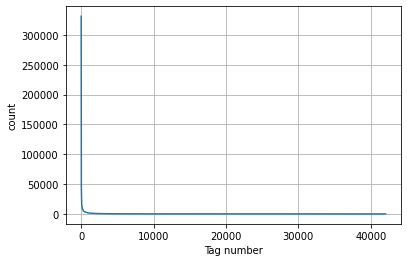

In [ ]:
#***ploting the count***#
plt.plot(tags_data['Count'].values)
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('count')
plt.show()

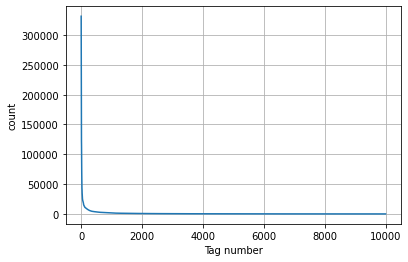

In [ ]:
#***ploting 10k pts****#
plt.plot(tags_data['Count'][0:10000].values)
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('count')
plt.show()

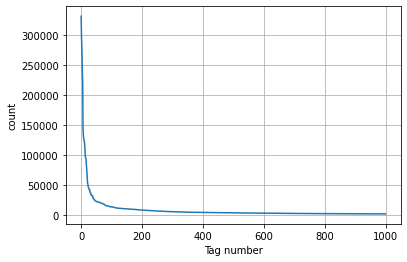

In [ ]:
 #***ploting top 1k pts****#
plt.plot(tags_data['Count'][0:1000].values)
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('count')
plt.show()

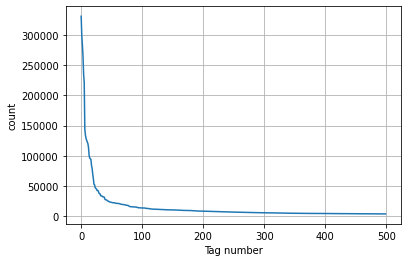

In [ ]:
 #***ploting top 500 pts****#
plt.plot(tags_data['Count'][0:500].values)
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('count')
plt.show()

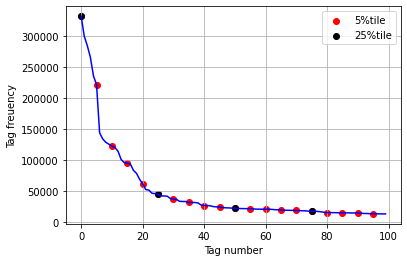

100 4338     331505
18609    221533
23453    122769
34271     95160
40380     62023
919       44829
9427      37170
10533     31897
26989     26925
2239      24537
40791     22429
1002      21820
25901     20957
34146     19758
35581     18905
11496     17728
1715      15533
17400     15097
16        14884
25483     13703
Name: Count, dtype: int64


In [ ]:
#***ploting the quantials***#
x = list(range(0,100,25))
plt.plot(tags_data['Count'][0:100].values,c='b')
plt.scatter(list(range(0,100,5)),tags_data['Count'][0:100:5].values,c='red',label='5%tile')
plt.scatter(x,tags_data['Count'][0:100:25].values,c='black',label='25%tile')
plt.grid()
plt.xlabel('Tag number')
plt.legend()
plt.ylabel('Tag freuency')
plt.show()

In [ ]:
print(min(tags_data['Count'].values))

1


## Observations:
#### 1.There are total 153 tags that occur 10k times
#### 2. 20 tags with 1L times occur
#### 3.max frequency(C#) 331505
#### 4. min frequency is 1
#### 5. since some tags occure much more frequently Micro-f1-scro is the best matrix to be used 

In [ ]:
tag_par_question = dict(no_dup['Tag_cnt'].value_counts())
tag_par_question

{1: 568298, 2: 1111706, 3: 1206157, 4: 814996, 5: 505158}

<BarContainer object of 5 artists>

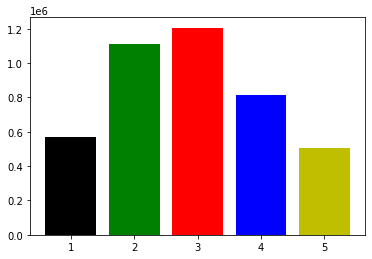

In [ ]:
plt.bar(tag_par_question.keys(),tag_par_question.values(),color='rgbkymc')

## Observations:
#### 1. max tags are 5
#### 2. min tag ia 1
#### 3. most question have 2/3 tags

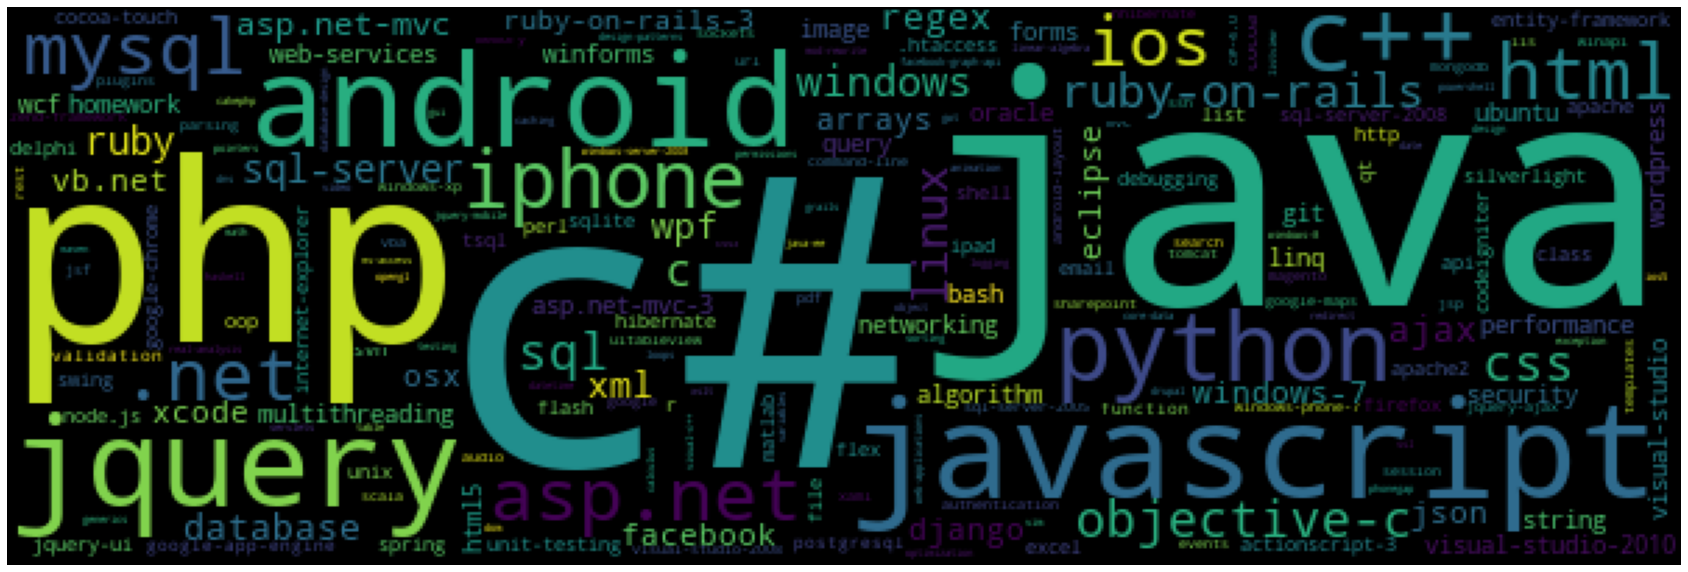

In [ ]:
### most frequent tags
start = datetime.now()
wordcloud = WordCloud(width=600,height=200).generate_from_frequencies(uq_tag_freq)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis("off")
fig.savefig("tag.png")
plt.show()

word size tell the frequency of the word (frq is large then size of word will be large)

In [ ]:
### geting the top 20 tags
plt.bar(tags_data['Tags'].head(30),tags_data['Count'].head(30))
plt.show()

NameError: ignored